In [1]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
import  os
os.environ['TF_USE_LEGACY_KERAS']  =  'True'

import ktrain
from ktrain import tabular
from  ktrain  import  load_predictor
import os
import glob
import optuna
import pickle
import json

# import  ktrain
# from  ktrain  import  tabular
# from  tensorflow.keras  import  utils
def read_and_combine(feature,mode="training"):
    if mode=="training":
        all_files = glob.glob(os.path.join("./multi_backend_model_data/Q_learn_train", "*.csv"))
        df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
        cols = [x for x in df.columns if x not in ["Avg_inverted_error","observed_prob_25","observed_prob_75",feature]]
        return df.loc[:,cols]
    elif mode=="testing":
        all_files = glob.glob(os.path.join("./multi_backend_model_data/Q_learn_test", "*.csv"))
        df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
        cols = [x for x in df.columns if x not in ["Avg_inverted_error","observed_prob_25","observed_prob_75",feature]]
        return df.loc[:,cols]
# 用于获取某一csv文件的data
def get_test_data(path,feature):
    df = pd.read_csv(path) 
    cols = [x for x in df.columns if x not in ["Avg_inverted_error","observed_prob_25","observed_prob_75",feature]]
    return df.loc[:,cols]
# 用于获取含噪声的值
def get_noisy_data(path):
    df = pd.read_csv(path)
    cols = [x for x in df.columns if x in ["observed_prob_50"]]
    return df.loc[:,cols]
def read_hardware():
    all_files = glob.glob(os.path.join("./real_circuits_hardware/", "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    cols = [x for x in df.columns if x not in ["Avg_inverted_error","observed_prob_25","observed_prob_75"]]
    return df.loc[:,cols]

In [2]:
def HellingerDistance_1(p, q):
    import numpy as np
    p = np.array(p)
    q = np.array(q)
    # p[p<=0] = 0
    # q[q<=0] = 0
    return  np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q))**2)) / np.sqrt(2)
def HellingerDistance(p, q):
    q[q<0] = 0
    p = p/100
    q = q/100
    n = len(p)
    sum_ = 0.0
    for i in range(n):
        sum_ += (np.sqrt(p[i]) - np.sqrt(q[i]))**2
    result = (1.0 / np.sqrt(2.0)) * np.sqrt(sum_)
    return result

processing train: 488269 rows x 11 columns
['target']
   target
0    2.11
1    0.14
2    0.05
3    0.46
4    2.86


c:\Users\30806\.conda\envs\test\lib\site-packages\ktrain\utils.py:727: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  warnings.warn(


processing test: 901531 rows x 11 columns
['target']
   target
0    0.76
1    0.11
2    0.00
3    0.07
4    0.00
done.
simulating training for different learning rates... this may take a few moments...
Epoch 1/16
3814/3814 [==============================] - 224s 58ms/step - loss: 4.2934 - mse: 4.2934
Epoch 2/16
3814/3814 [==============================] - 128s 33ms/step - loss: 3.9437 - mse: 3.9437
Epoch 3/16
3814/3814 [==============================] - 112s 29ms/step - loss: 2.9434 - mse: 2.9434
Epoch 4/16
3814/3814 [==============================] - 112s 29ms/step - loss: 1.1132 - mse: 1.1132
Epoch 5/16
3814/3814 [==============================] - 112s 29ms/step - loss: 0.6663 - mse: 0.6663
Epoch 6/16
3814/3814 [==============================] - 112s 29ms/step - loss: 0.6059 - mse: 0.6059
Epoch 7/16
3814/3814 [==============================] - 113s 30ms/step - loss: 0.6262 - mse: 0.6262
Epoch 8/16
3814/3814 [==============================] - 113s 30ms/step - loss: 0.6672 - mse: 0.667

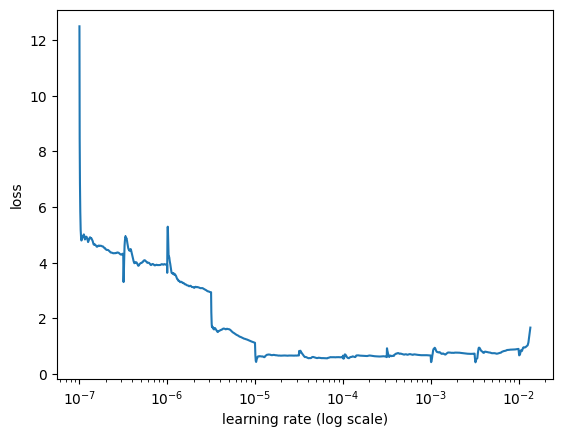



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1024
3815/3815 [==============================] - 1327s 348ms/step - loss: 1.0248 - mse: 1.0248 - val_loss: 0.3614 - val_mse: 0.3614
Epoch 2/1024
3815/3815 [==============================] - 1353s 355ms/step - loss: 0.6086 - mse: 0.6086 - val_loss: 0.3319 - val_mse: 0.3319
Epoch 3/1024
3815/3815 [==============================] - 1391s 365ms/step - loss: 0.5816 - mse: 0.5816 - val_loss: 0.3175 - val_mse: 0.3175
Epoch 4/1024
3815/3815 [==============================] - 1492s 391ms/step - loss: 0.5857 - mse: 0.5857 - val_loss: 0.3485 - val_mse: 0.3485
Epoch 5/1024
3815/3815 [==============================] - 1491s 391ms/step - loss: 0.5751 - mse: 0.5751 - val_loss: 0.3027 - val_mse: 0.3027
Epoch 6/1024
3815/3815 [==============================] - 1491s 391ms/step - loss: 0.5714 - mse: 0.5714 - val_loss: 0.3295 - val_mse: 0.3295
Epoch 7/1024
3815/3815 [==============================] - 1531s 401ms/step

In [3]:
# model training
mlp_training_data = read_and_combine(None)
mlp_test_data = read_and_combine(None,mode="testing")
mlp_training_data = mlp_training_data.astype('float')
mlp_test_data = mlp_test_data.astype('float')

trn, val, preproc = tabular.tabular_from_df(mlp_training_data, is_regression=True, 
                                             label_columns='target', val_df=mlp_test_data)
mlp = tabular.tabular_regression_model('mlp', trn, hidden_layers=[128,1000,128],
                                       hidden_dropouts=[0,0.5,0], metrics=['mse'], bn=False)

learner = ktrain.get_learner(mlp, train_data=trn, val_data=val, batch_size=128)
learner.lr_find(show_plot=True, max_epochs=16)
learner.autofit(lr=1e-4,early_stopping=20,reduce_on_plateau=3)

In [4]:
# model save
mlp_predictor = ktrain.get_predictor(learner.model, preproc)
mlp_predictor.save("Q_learn_mlp")

In [ ]:
def save_HLD(model_name,HLD_list):
    # 定义两个字典
    HLD_dict = {}
    HLD_dict[model_name] = HLD_list
    # 读取已有的 JSON 文件内容
    with open('./multi_backend_model_data/HLD.json', 'r') as file:
        data = json.load(file)

    # 将第二个字典追加到已有内容中
    data.update(HLD_dict)

    # 将更新后的内容写回 JSON 文件
    with open('./multi_backend_model_data/HLD.json', 'w') as file:
        json.dump(data, file)


#### ①test Q-LEAR model on MQT test set

In [10]:
test_path = './multi_backend_model_data/Q_learn_MQT_test'
paths = glob.glob(os.path.join(test_path, "*.csv"))
test_data_list = []
noisy_data_list = []
circuits_qubits_list = []
for path in paths:
        path_i = os.path.basename(path)
        qubit = path_i.split('.')[0].split('_')[-2]
        backend_name = path_i.split('.')[0].split('_')[1]+ '_' + path_i.split('.')[0].split('_')[2]
        circuits_qubits_list.append(qubit)
        test_data = get_test_data(path,None)
        noisy_data = get_noisy_data(path)
        test_data_list.append(test_data)
        noisy_data_list.append(noisy_data)

In [11]:
# for MQT test
HLD_dict = {}
HLD_dict['4'] = []
HLD_dict['5'] = []
HLD_dict['6'] = []
HLD_dict['7'] = []
HLD_dict['8'] = []
HLD_dict['9'] = []
HLD_dict['10'] = []
HLD_dict['11'] = []
HLD_dict['12'] = []
HLD_dict['13'] = []
mlp_predictor = load_predictor('Q_learn_mlp')
for index,test_data in enumerate(test_data_list):
    preds = mlp_predictor.predict(test_data)
    qubit = circuits_qubits_list[index]
    ideal = test_data["target"].values/100
    mited = preds/100
    ideal[ideal<0] = 0
    mited[mited<0] = 0
    mited  =  [item[0]  for  item  in  mited]
    ideal = ideal/sum(ideal)
    mited = mited/sum(mited)
    HLD_i = HellingerDistance_1(ideal,mited)
    HLD_dict[qubit].append(HLD_i)

['target']
   target
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
['target']
   target
0    0.10
1    0.10
2    0.11
3    0.10
4    0.11
['target']
   target
0    0.00
1    0.50
2   44.27
3    0.00
4    0.00
['target']
   target
0    0.00
1    1.62
2    0.00
3    0.20
4    0.00
['target']
   target
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
['target']
   target
0    0.01
1    0.00
2    0.00
3    0.00
4    0.00
['target']
   target
0    0.00
1    1.09
2    1.09
3    0.00
4    0.04
['target']
   target
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
['target']
   target
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
['target']
   target
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
['target']
   target
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
['target']
   target
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
['target']
   target
0    0.06
1    0.06
2    0.05
3    0.05
4    0.06
['target']
   target
0    0.00
1    0.30
2    0.00
3    0.00
4    2.87
['targ

In [12]:
Q_learn_MQT = []
for key in HLD_dict:
    Q_learn_MQT.append(sum(HLD_dict[key])/len(HLD_dict[key]))
Q_learn_MQT = Q_learn_MQT[1:]
print(Q_learn_MQT)

[0.19422533049609383, 0.23450263322805923, 0.288501715337796, 0.36577218692811725, 0.4005615227122953, 0.4684375833399767, 0.6070710563589008, 0.7043196535341678, 0.70843746069511]


In [ ]:
save_HLD('Q_learn_MQT_model',Q_learn_MQT)

### ②test Q-LEAR model on random test set

In [ ]:
# 加载测试数据,按比特数
# test_path = './multi_backend_model_data/Q_learn_MQT_test'
test_path = './multi_backend_model_data/Q_learn_test'
paths = glob.glob(os.path.join(test_path, "*.csv"))
test_data_list = []
noisy_data_list = []
# 用于记录线路比特数
circuits_qubits_list = []
for path in paths:
        path_i = os.path.basename(path)
        qubit = path_i.split('.')[0].split('_')[-2]
        backend_name = path_i.split('.')[0].split('_')[1]+ '_' + path_i.split('.')[0].split('_')[2]
        circuits_qubits_list.append(qubit)
        test_data = get_test_data(path,None)
        noisy_data = get_noisy_data(path)
        test_data_list.append(test_data)
        noisy_data_list.append(noisy_data)

In [8]:
# for MQT test
HLD_dict = {}
HLD_dict['2'] = []
HLD_dict['3'] = []
HLD_dict['4'] = []
HLD_dict['5'] = []
HLD_dict['6'] = []
HLD_dict['7'] = []
HLD_dict['8'] = []
HLD_dict['9'] = []
HLD_dict['10'] = []
HLD_dict['11'] = []
HLD_dict['12'] = []
HLD_dict['13'] = []
mlp_predictor = load_predictor('Q_learn_mlp')
for index,test_data in enumerate(test_data_list):
    preds = mlp_predictor.predict(test_data)
    qubit = circuits_qubits_list[index]
    ideal = test_data["target"].values/100
    mited = preds/100
    ideal[ideal<0] = 0
    mited[mited<0] = 0
    mited  =  [item[0]  for  item  in  mited]
    ideal = ideal/sum(ideal)
    mited = mited/sum(mited)
    HLD_i = HellingerDistance_1(ideal,mited)
    HLD_dict[qubit].append(HLD_i)

['target']
   target
0    0.76
1    0.11
2    0.00
3    0.07
4    0.00
['target']
   target
0    0.00
1    0.00
2    0.00
3    0.00
4    1.77
['target']
      target
0  25.080000
1  24.719999
2   0.000000
3   0.000000
4   0.000000
['target']
      target
0   0.000000
1  18.309999
2   0.000000
3  18.160000
4   3.910000
['target']
   target
0    0.00
1    0.00
2    0.07
3    0.00
4    0.00
['target']
   target
0    0.00
1    0.00
2   10.35
3    0.00
4    0.00
['target']
   target
0    0.00
1    0.00
2    0.00
3    0.98
4    0.00
['target']
   target
0    0.00
1   11.72
2    7.73
3    0.00
4    0.00
['target']
   target
0    0.00
1    3.09
2    0.00
3    3.13
4    3.13
['target']
   target
0     0.0
1     0.0
2     0.0
3     5.5
4     0.0
['target']
   target
0   11.36
1    0.00
2    0.00
3    0.00
4    0.00
['target']
   target
0    0.00
1    0.00
2    1.32
3    0.00
4    7.58
['target']
   target
0    0.00
1    0.00
2    0.00
3    6.68
4    0.00
['target']
   target
0    8.81
1    0.00


In [9]:
Q_learn_model = []
for key in HLD_dict:
    Q_learn_model.append(sum(HLD_dict[key])/len(HLD_dict[key]))
    print(f"{key} qubits HLD:{sum(HLD_dict[key])/len(HLD_dict[key])}")

2 qubits HLD:0.042419470628376164
3 qubits HLD:0.06914280984102246
4 qubits HLD:0.11087999483818825
5 qubits HLD:0.12370702735375551
6 qubits HLD:0.15401135184912998
7 qubits HLD:0.18685365986407623
8 qubits HLD:0.23014424426867167
9 qubits HLD:0.2578410059410543
10 qubits HLD:0.3109376611090947
11 qubits HLD:0.4033916532975067
12 qubits HLD:0.5591839215329345
13 qubits HLD:0.6634722542194674


In [ ]:
save_HLD('Q_learn_model',Q_learn_model)